In [1]:
import os
import sys
# # Set GPU or CPU; -1: CPU
# 0, 1, 2, 3: GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
sys.path.append("../src")
sys.path.append("../src/onetlib")

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import onsagernet as onet
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

In [4]:
tf.__version__

'2.9.1'

# Import and Extract Data
## weather_project

In [11]:
# Load weather data
# Shape = (number of time, dimension) = (*, 10)
data_train = np.load('weather_data/weather_data/ori_exac_train.npy')
data_valid = np.load('weather_data/weather_data/ori_exac_valid.npy')
data_test = np.load('weather_data/weather_data/ori_exac_test.npy')

In [12]:
def extract_sequences(features, targets, target_time, shuffle=False):
    """extract sequence function."""
    extract_length = int(target_time)
    x = features[:-extract_length,:]
    y = targets[extract_length:,:]
    return x, y

# Build Functions

In [13]:
import onetlib.onsagernet as onet

In [14]:
alpha = 0.01
beta = 0.5
n_pot = 10
pot_layer_sizes = [128,1024,1024]
dc_layer_sizes = [4,4]
fc_layer_sizes = [128,1024]
n_features = 10

In [15]:
# build Onsager net 
def build_onsager_net():
    potential_net = onet.FCPotentialNet(beta = beta,
                                       layer_sizes = pot_layer_size,
                                       n_pot = n_features)
    dissconv_net = onet.FCDissConsNet(n_dim = n_features,
                                     layer_sizes = dc_layer_sizes)
    forcing_net = onet.FCForcingNet(n_dim = n_features)
    onsager_net = onet.OnsagerNet(n_dim = n_features,
                                  potential_net = potential_net,
                                  dissconv_net = dissconv_net,
                                  forcing_net = forcing_net,
                                  alpha = alpha)
    inputs = tf.keras.Input((n_features,))
    outputs = onsager_net(inputs)
    onsager_rhs = tf.keras.Model(inputs,outputs,name = 'onsager_rhs')
    return onsager_rhs

# Build Model

In [16]:
t = 1.0
T = 6.0

In [17]:
# Seperate data to input and output
train_x, train_y = extract_sequences(data_train, data_train, target_time= T)
valid_x, valid_y = extract_sequences(data_valid, data_valid, target_time= T)
test_x, test_y = extract_sequences(data_test, data_test, target_time= T)

In [18]:
model = onet.ODEOnsagerNet(n_features = n_features,delta_t = delta_t,OnsagerNet = build_onsager_net())
model.build(input_shape = (None,n_features))
model.summary()

NameError: name 'delta_t' is not defined

In [13]:
model.summary()

Model: "onsager_pred"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 euler_onsager_layer (EulerOnsa  (None, 10)          1337672     ['input_1[0][0]',                
 gerLayer)                                                        'euler_onsager_layer[0][0]',    
                                                                  'euler_onsager_layer[1][0]',    
                                                                  'euler_onsager_layer[2][0]',    
                                                                  'euler_onsager_layer[3][0]',    
                                                                  'euler_onsager_layer[

# Compile the Model

In [14]:
epochs = 5
lr = 1.0e-3
lr_factor = 0.1
min_lr  =1.0e-5
clipvalue = 1.0
cooldown = 0
patience_es = 30
patience_lr = 10
forcast_horizon = 1
jumps = 1
lead_time = 6
train_batch_size = 512
valid_batch_size = 128

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr), 
              loss='mse')

In [16]:
# Callback
# Early-stopping
cb_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            min_delta=0, 
                                            patience= patience_es, 
                                            verbose=1, 
                                            mode='auto')
# ReduceLROnPlateau
cb_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                             factor= lr_factor,
                                             patience= patience_lr,
                                             min_lr= min_lr,
                                             cooldown= cooldown,
                                             verbose=0)

In [17]:
history =  model.fit(x= train_x, 
                     y= train_y,
                     validation_data=(valid_x, valid_y),
                     epochs= epochs,
                     batch_size= train_batch_size,
                     validation_batch_size= valid_batch_size,
                     callbacks=[cb_lr, cb_es]
                    )

Epoch 1/5
446/446 [==============================] - 88s 185ms/step - loss: 1.0653 - val_loss: 0.7986 - lr: 0.0010
Epoch 2/5
182/446 [===========>..................] - ETA: 38s - loss: 0.7728

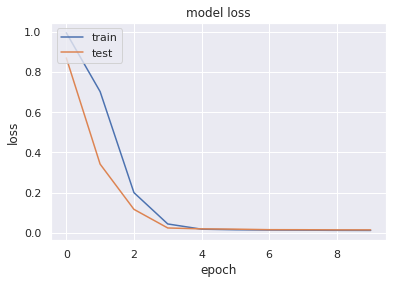

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evaluation

In [ ]:
def calc_results(pred, exac, start_time, pred_period, time_step, model):
    results_list = [tf.reshape(pred[start_time], shape=(1,10))]
    n_iterations = int(pred_period / time_step)
    for i in range(n_iterations):
        result = model.predict(results_list[-1])
        results_list.append(result)
    pred_list = tf.reshape(results_list, shape=(n_iterations+1,10))
    
    exac_list = exac[start_time:start_time+ pred_period+1][::time_step,:]
    return pred_list, exac_list

In [ ]:
# Continuous 120hrs forecast
# Time step is 6 hrs.
pred_period=120
time_step=6
x_range = np.linspace(0,120,int(pred_period/time_step)+1)

In [ ]:
pred_train, exac_train = calc_results(pred=train_x, 
                                      exac=train_x, 
                                      start_time=100, 
                                      pred_period=pred_period, 
                                      time_step=time_step, 
                                      model = model)
pred_test, exac_test = calc_results(pred=test_x, 
                                    exac=test_x, 
                                    start_time=100, 
                                    pred_period=pred_period, 
                                    time_step=time_step, 
                                    model = model)

## Evaluation on Training Data

In [ ]:
norm2_pred_train = tf.norm(pred_train, ord=2, axis=-1)
norm2_exac_train = tf.norm(exac_train, ord=2, axis=-1)

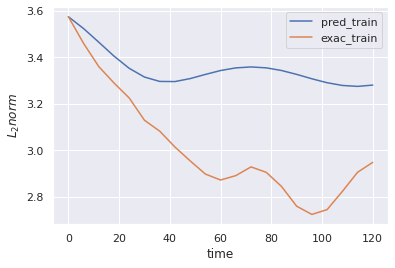

In [ ]:
plt.plot(x_range, norm2_pred_train, label='pred_train')
plt.plot(x_range, norm2_exac_train, label='exac_train')
plt.xlabel('time')
plt.ylabel('$L_{2} norm$')
plt.legend()

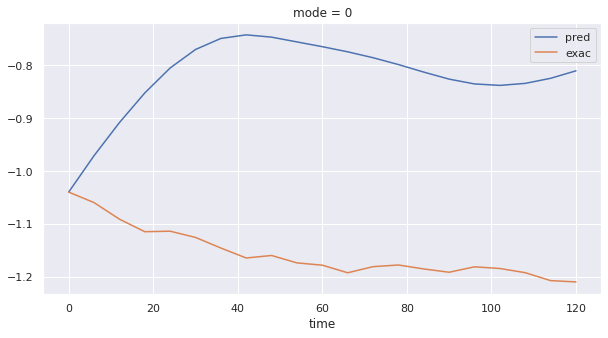

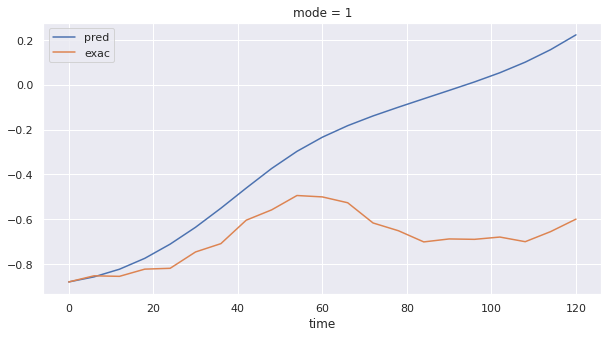

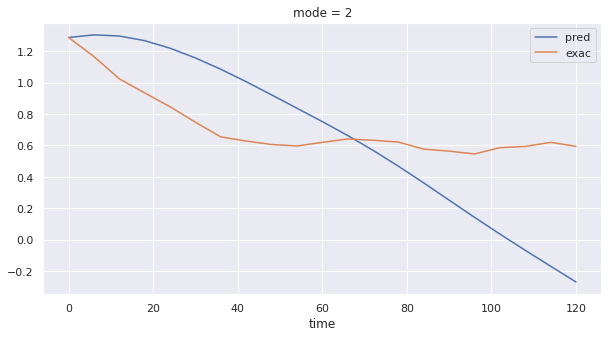

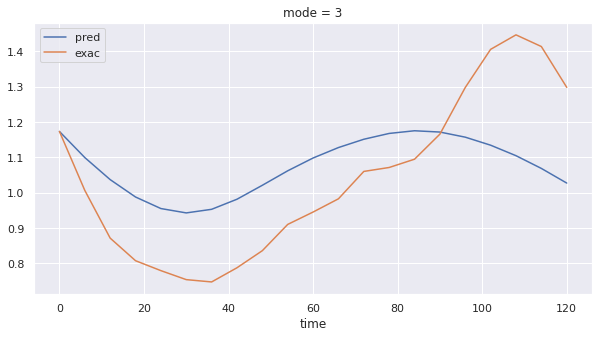

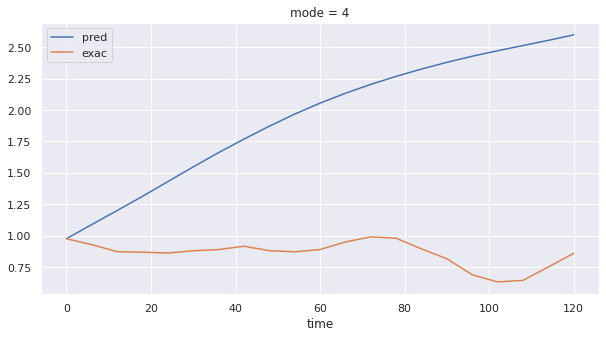

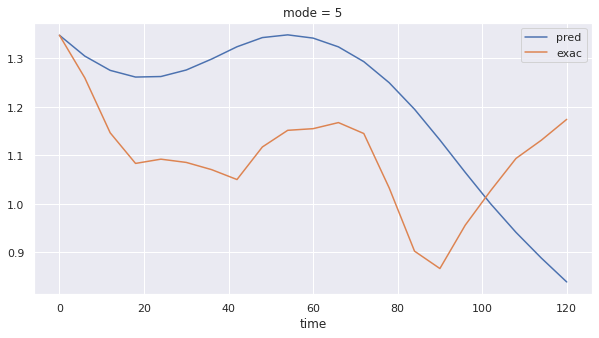

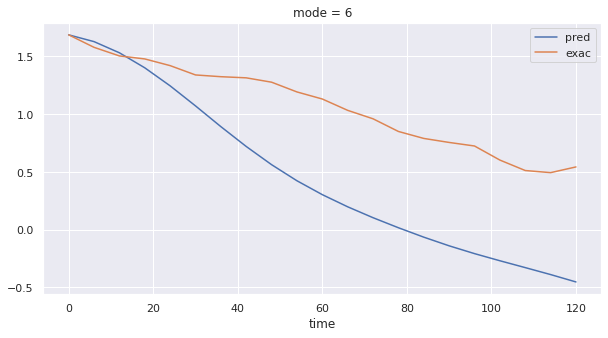

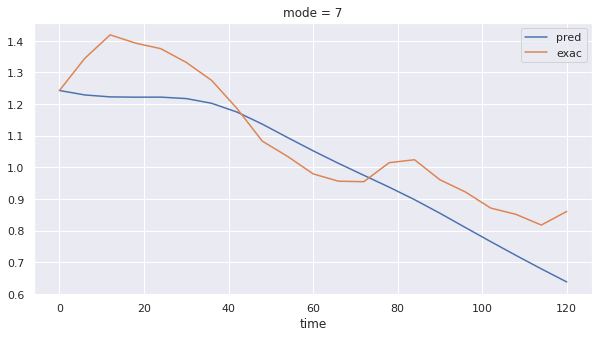

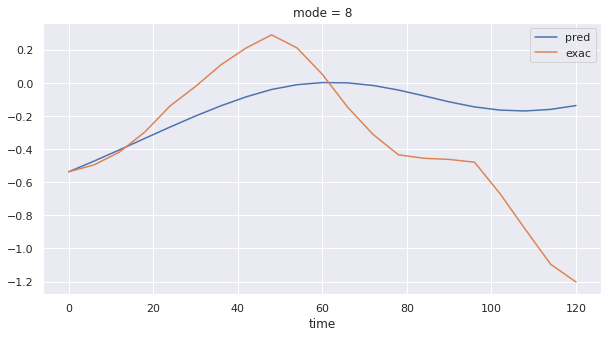

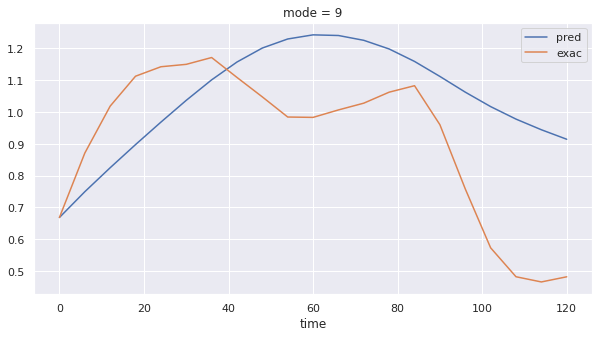

In [ ]:
# Plot on each dimension
for i in range(10):   
    plt.figure(figsize=(10,5))
    plt.title('mode = ' +str(i))
    plt.plot(x_range, pred_train[:,i], label='pred')
    plt.plot(x_range, exac_train[:,i], label='exac')
    plt.xlabel('time')
    plt.legend()
#     plt.savefig('train_continuous_pred_mode'+str(i)+'.png', dpi=200, bbox_inches='tight')

## Evaluation on Testing Data

In [ ]:
norm2_pred_test = tf.norm(pred_test, ord=2, axis=-1)
norm2_exac_test = tf.norm(exac_test, ord=2, axis=-1)

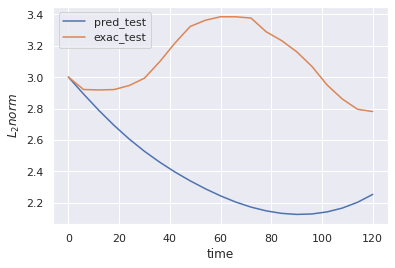

In [ ]:
plt.plot(x_range, norm2_pred_test, label='pred_test')
plt.plot(x_range, norm2_exac_test, label='exac_test')
plt.xlabel('time')
plt.ylabel('$L_{2} norm$')
plt.legend()

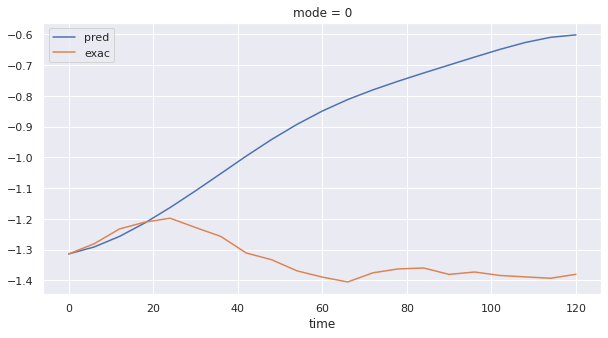

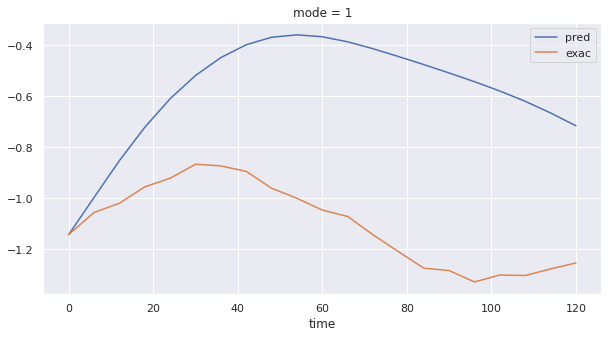

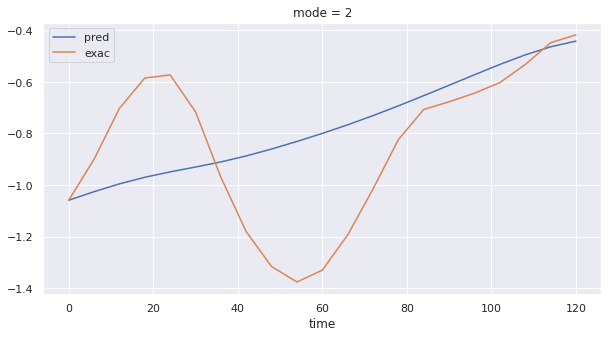

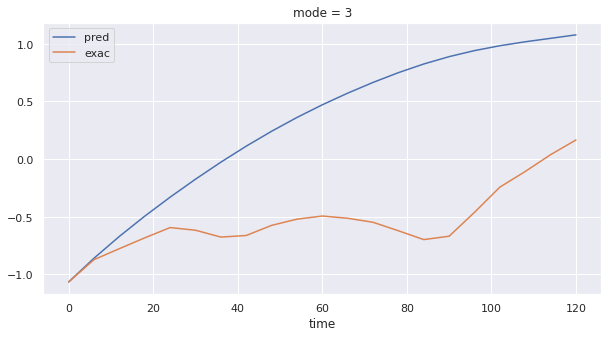

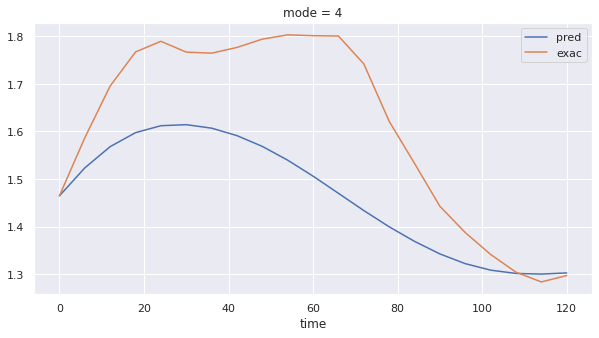

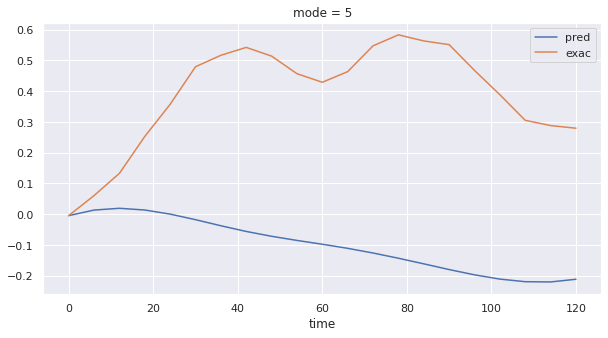

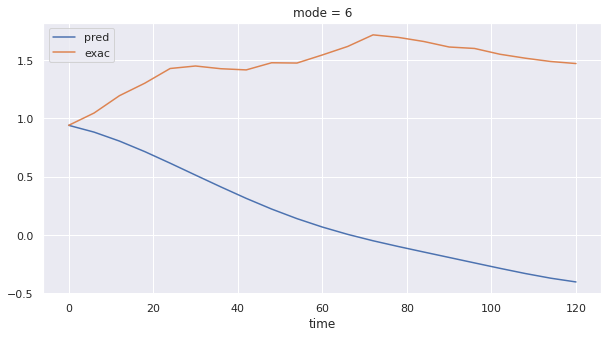

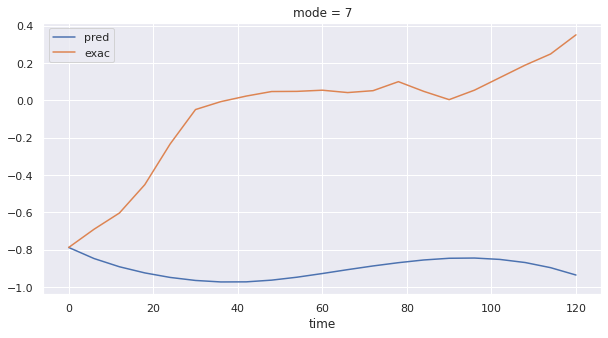

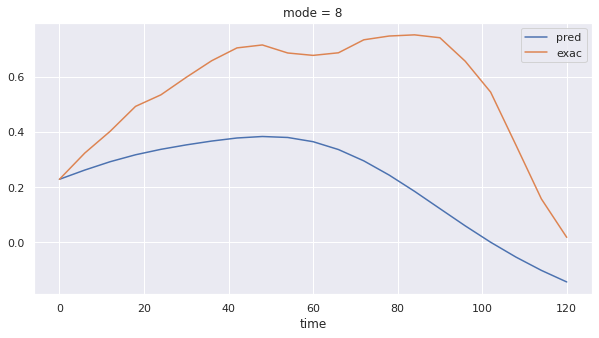

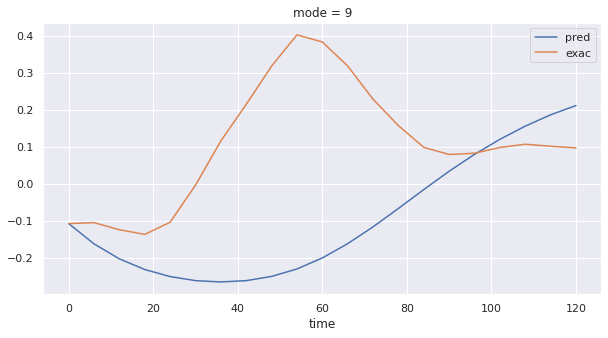

In [ ]:
# Plot on each dimension
for i in range(10):   
    plt.figure(figsize=(10,5))
    plt.title('mode = ' +str(i))
    plt.plot(x_range, pred_test[:,i], label='pred')
    plt.plot(x_range, exac_test[:,i], label='exac')
    plt.xlabel('time')
    plt.legend()
#     plt.savefig('test_continuous_pred_mode'+str(i)+'.png', dpi=200, bbox_inches='tight')